In [138]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import numpy as np
import pandas as pd
import datetime
import os
import csv
import random
import io
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [139]:
num_lags = 3
timesteps = 10
err_range = 0.5

In [140]:
# read in data
df = pd.read_csv('../j17_well.csv')
pd.DataFrame.reset_index(df, drop=True)
del df['Site']
# standardize data
def z_score_calc(dataframe,col_name):
    sub = dataframe[col_name]
    mean = sub.mean()
    std = sub.std()
    dataframe['Z Scores'] = (sub - mean) / std
    return dataframe['Z Scores'], mean, std
z_scores = pd.DataFrame()
pd.DataFrame.reset_index(z_scores, drop=True)
z_scores["DailyHighDate"] = df['DailyHighDate']
z_scores['WaterLevelElevation'] = df['WaterLevelElevation']
z_scores['Z Scores'], mean, std = z_score_calc(df,'WaterLevelElevation')
z_scores.to_csv("j17wl_daily_z_scores.csv")
# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    if gwl_num > 1:
        result['Max GWL (predicted,updated): t+' + str(gwl_num-1)] = data[0:len(data)-num_lags-gwl_num+1]
    else:
        result['Max GWL (predicted,updated): t'] = data[0:len(data)-num_lags-gwl_num+1]
    #result = result.sample(frac=1)
    result.to_csv(csv_name)
make_csv(num_lags,timesteps,z_scores,'Z Scores','data.csv')
# prepare data
cols = []
for i in range(num_lags):
    cols.append(i+1)
ds_x = np.genfromtxt('data.csv',delimiter=",",usecols=cols)
ds_y = np.genfromtxt('data.csv',delimiter=",",usecols=num_lags+1)
ds_x = ds_x[1:] # remove header
ds_y = ds_y[1:]
# ~80% training
ds_train_x = ds_x[:int(0.8*len(ds_x))]
ds_train_y = ds_y[:int(0.8*len(ds_x))]
# ~20% validating
ds_val_x = ds_x[int(0.8*len(ds_x)):]
ds_val_y = ds_y[int(0.8*len(ds_x)):]
# reshape data from [samples, timesteps] into [samples, timesteps, features]
ds_train_x = ds_train_x.reshape((ds_train_x.shape[0], ds_train_x.shape[1], 1))
ds_val_x = ds_val_x.reshape((ds_val_x.shape[0], ds_val_x.shape[1], 1))

In [141]:
# build LSTM
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(num_lags, 1)))
model.add(LSTM(30))
#model.add(LSTM(10, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(ds_train_x, ds_train_y, epochs=40)
# apply to predictions
predictions = model.predict(ds_val_x)
result = []
for i in predictions:
  result.append(i[0])
result = np.array(result)
predicted_vals = result * std + mean
true_vals = ds_val_y * std + mean
diff = true_vals - predicted_vals
count_err = 0
count_1 = 0
for i in diff:
    if abs(i) <= err_range:
      count_err += 1
    if abs(i) <= 1.0:
      count_1 += 1
print("Predictions ±" + str(err_range) + " = " + str(count_err / len(diff) * 100) + "%")
print("Predictions ±1.0 = " + str(count_1 / len(diff) * 100) + "%")
corr_m = np.corrcoef(ds_val_y*std+mean, result*std+mean)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")

Epoch 1/40
789/789 [==============================] - 4s 2ms/step - loss: 0.0754
Epoch 2/40
789/789 [==============================] - 1s 2ms/step - loss: 0.0370
Epoch 3/40
789/789 [==============================] - 2s 2ms/step - loss: 0.0367
Epoch 4/40
789/789 [==============================] - 2s 2ms/step - loss: 0.0363
Epoch 5/40
789/789 [==============================] - 1s 2ms/step - loss: 0.0354
Epoch 6/40
789/789 [==============================] - 1s 2ms/step - loss: 0.0343
Epoch 7/40
789/789 [==============================] - 1s 2ms/step - loss: 0.0328
Epoch 8/40
789/789 [==============================] - 2s 2ms/step - loss: 0.0310
Epoch 9/40
789/789 [==============================] - 2s 2ms/step - loss: 0.0302
Epoch 10/40
789/789 [==============================] - 2s 2ms/step - loss: 0.0297
Epoch 11/40
789/789 [==============================] - 2s 2ms/step - loss: 0.0297
Epoch 12/40
789/789 [==============================] - 2s 2ms/step - loss: 0.0295
Epoch 13/40
789/789 [====

In [135]:
plt.rcParams['font.family'] = 'serif'
f='Times'

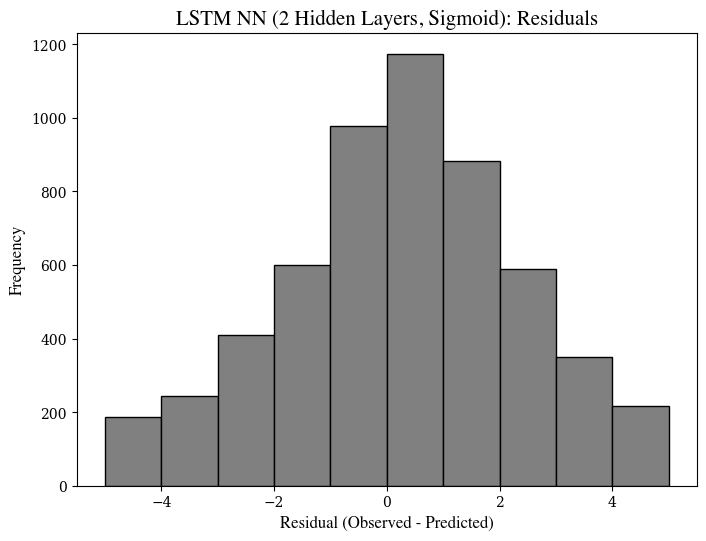

In [126]:
fig, ax = plt.subplots(1, 1)
ax.hist(diff,range=[-5, 5],facecolor='grey',edgecolor='black')
ax.set_title("LSTM NN (2 Hidden Layers, Sigmoid): Residuals", family=f, size=15)
ax.set_xlabel("Residual (Observed - Predicted)", family=f, size=12)
ax.set_ylabel("Frequency", family=f, size=12)
plt.show()

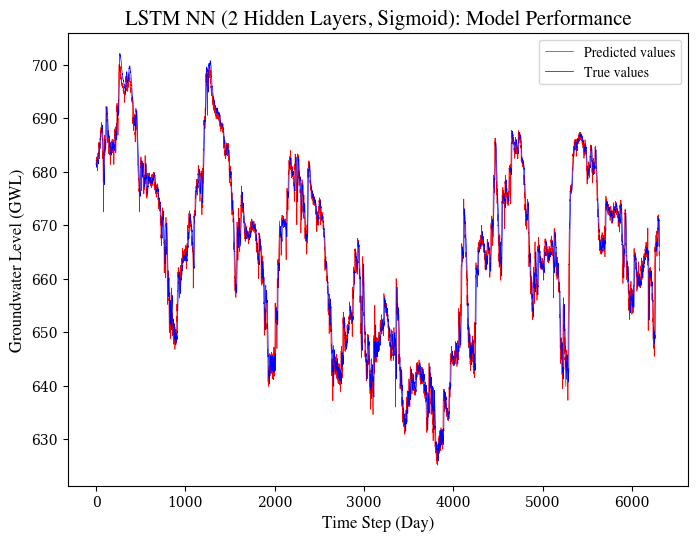

In [127]:
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title("LSTM NN (2 Hidden Layers, Sigmoid): Model Performance", family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})

In [128]:
plt.rcParams['font.family'] = 'sans-serif'
f='Avenir'

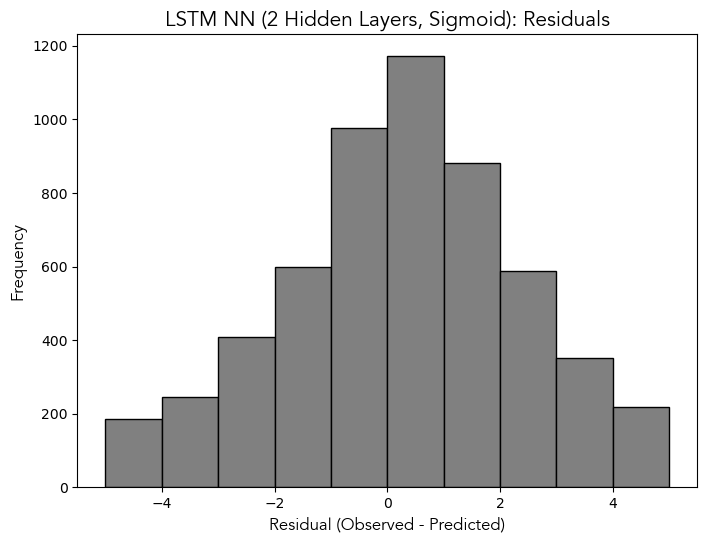

In [129]:
fig, ax = plt.subplots(1, 1)
ax.hist(diff,range=[-5, 5],facecolor='grey',edgecolor='black')
ax.set_title("LSTM NN (2 Hidden Layers, Sigmoid): Residuals", family=f, size=15)
ax.set_xlabel("Residual (Observed - Predicted)", family=f, size=12)
ax.set_ylabel("Frequency", family=f, size=12)
plt.show()

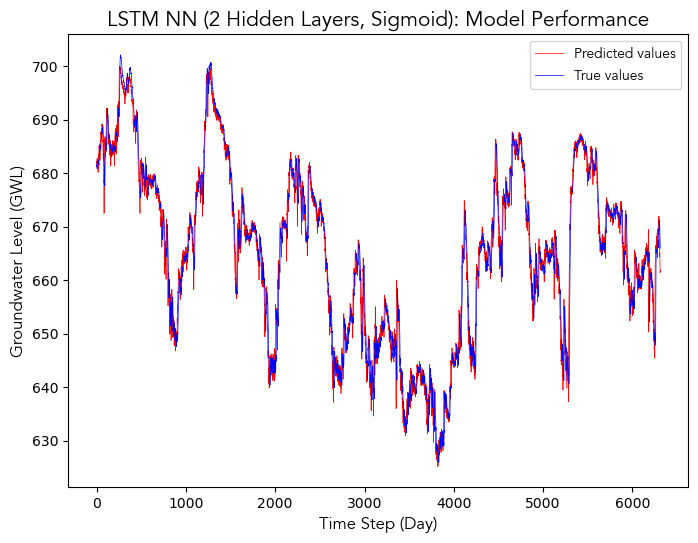

In [130]:
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title("LSTM NN (2 Hidden Layers, Sigmoid): Model Performance", family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})